In [36]:
import numpy as np
import re
import math 
import random
import os
import scipy.stats as stats
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from matplotlib.lines import Line2D


random.seed(42)

In [2]:
def get_data(datafile):
    """COPIED FROM MORIARTY AND TWEAKED
    N         : number of experiments (columns in the table)
    G         : number of genes (rows in the table)
    X[i]      : array of time points, in hrs, for the N experiments
    S_true[i] : array of sigmas for the experiments
    Y[i][t]   : GxN: observed tpm for gene i, time point t"""
    with open(datafile) as f:
        # First header line gives us the time points
        fields = f.readline().split()
        X = []
        for s in fields:
            match = re.search(r'^(\d+)hr', s)
            X.append(int(match.group(1)))
        X = np.array(X)
        N = len(X)

        # Second header line gives us "gene" followed by +=SD's
        fields = f.readline().split()
        S_true = np.zeros(N)
        for i,s in enumerate(fields[1:]):
            match = re.search(r'^\+-(\d+)', s)
            S_true[i] = float(match.group(1))

        # Third header line is just ------ stuff
        f.readline()

        # Remaining lines are data
        genenames = []
        Y = []
        for line in f.readlines():
            fields = line.split()
            genenames.append(fields[0])
            Y.append( np.array( [ float(s) for s in fields[1:]] ))
        G = len(Y)
        
    return X, S_true, Y

def calc_mean_for_normal(a, b, phi, t):
    """Given paramters a, b, and phi, plus a time point t, calculates the mean for the gaussian according to
    the model from MCB112 PSET 7"""
    rads = 2*math.pi*(1/24)*(t+phi)
    mean = b + a*math.sin(rads)
    
    return mean
    

def calc_nll(params, data_vec, sigma_vec, time_vec):
    """Given a numpy array of paramters in the order [a, b, phi], as well as a vector of the data, a vector
    of the sigmas for each data point, and a vector of the time of each data point, calculates the negative 
    log likelyhood """
    a, b, phi = params[0], params[1], params[2]
    log_probs_list = []
    for z, x_z in enumerate(data_vec):
        mean = calc_mean_for_normal(a, b, phi, time_vec[z])
        sigma = sigma_vec[z]
        log_probs_list.append(stats.norm.logpdf(x_z, mean, sigma))
        
    nll = -sum(log_probs_list)
    
    return nll

def get_ml_ests(data_vec, sigma_vec, time_vec, num_iters):
        data_arr = np.asarray(data_vec)
        best_params_list = []
        best_fun_list = []
        # Iterate over every gene
        for gene_idx in range(data_arr.shape[0]):
            best_fun = -1
            best_params = -1
            # For each gene, run the optimizer multiple times with different start values
            for i in range(num_iters):
                # I chose this range as something that seems reasonable
                a0 = random.uniform(0,100)
                b0 = random.uniform(0,100)
                phi0 = random.uniform(0,24)
                start_params = np.array([a0, b0, phi0])
                result = minimize(calc_nll, start_params, (data_arr[gene_idx], sigma_vec, time_vec),
                                                          bounds=[(0,10**6), (0,10**6), (0,24)])
                
                if result.success == False: 
                    print("Optimizer failed")
                    break
                    
                if best_fun == -1 or result.fun < best_fun:
                    best_fun = result.fun
                    best_params = result.x
                    
            best_params_list.append(best_params)
            best_fun_list.append(best_fun)
            
        return best_params_list, best_fun_list
                    

In [3]:
# Get the data
data_list = get_data("w07-data.tbl")
time_arr, sigma_arr, data_arr = data_list[0], data_list[1], data_list[2]

# Get my parameter estimates and their negative log-likelyhoods
my_params_list, my_nll_list = get_ml_ests(data_arr, sigma_arr, time_arr, num_iters=10)

In [4]:
def get_moriarty_data():
    """Runs Moriarty's script and returns a list of his parameter estimates"""
    command = "./moriarty.py w07-data.tbl"
    r = os.popen(command) 
    output = r.readlines() 
    
    params_list = []
    
    for line_num, line in enumerate(output): 
        if line_num == 0 or line_num == 1: continue
        line = line.strip('\n')
        line = line.split();
        line = [float(i) for i in line[1:]]
        line[0], line[1] = line[1], line[0] # swap the order because I want [a, b, phi]
        params_list.append(line)
            
    return params_list

In [5]:
moriarty_params_list = get_moriarty_data()
moriarty_nll_list = []

for gene_idx, params in enumerate(moriarty_params_list):
    nll = calc_nll(params, data_arr[gene_idx], sigma_arr, time_arr)
    moriarty_nll_list.append(nll)
    

In [6]:
my_tot_nll = sum(my_nll_list)
moriarty_tot_nll = sum(moriarty_nll_list)

print("My total NLL: " + str(my_tot_nll))
print("Moriarty total NLL: " + str(moriarty_tot_nll))
print("My parameters are " + str(moriarty_tot_nll/my_tot_nll) + " times more likely than Moriarty's")

My total NLL: 322.3534702814483
Moriarty total NLL: 671.6832580005337
My parameters are 2.083685518924564 times more likely than Moriarty's


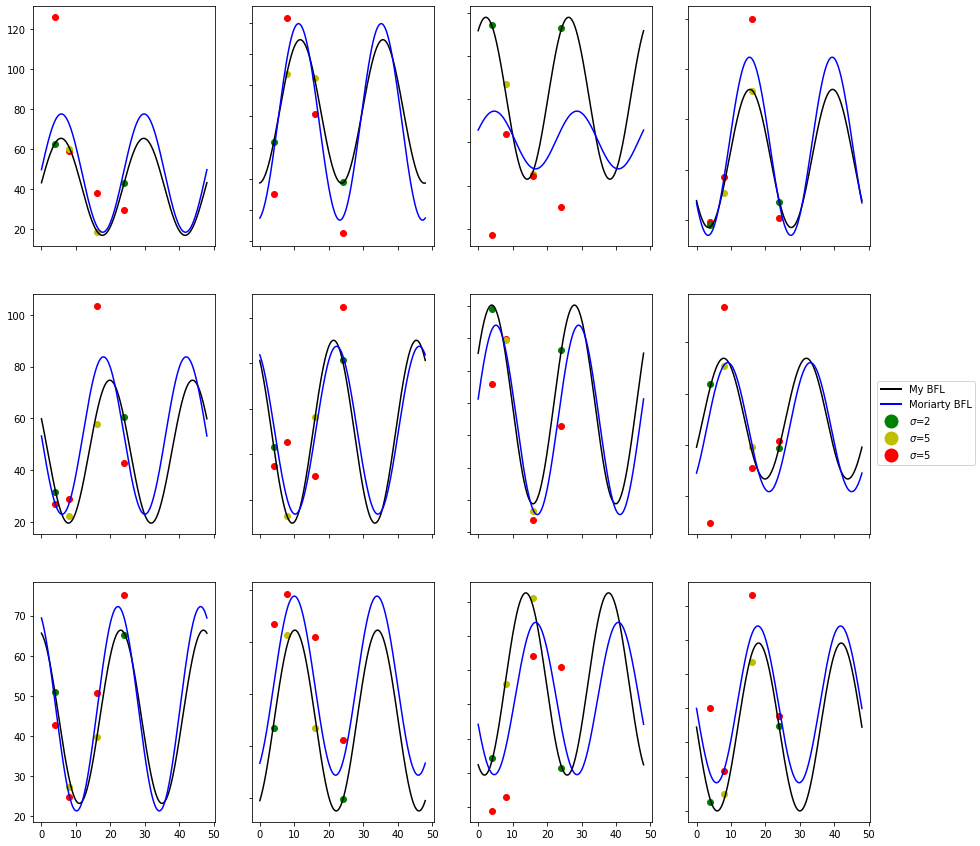

In [52]:
def get_plot_lines(idx, times):
    
    my_a, moriarty_a = my_params_list[idx][0], moriarty_params_list[idx][0]
    my_b, moriarty_b = my_params_list[idx][1], moriarty_params_list[idx][1]
    my_phi, moriarty_phi = my_params_list[idx][2], moriarty_params_list[idx][2]
    
    my_bf_line = [calc_mean_for_normal(my_a, my_b, my_phi, t) for t in times]
    moriarty_bf_line = [calc_mean_for_normal(moriarty_a, moriarty_b, moriarty_phi, t) for t in times]
    
    return my_bf_line, moriarty_bf_line
    
colormap = {2:'g', 5:'y', 20:'r'}
times = np.linspace(0,48,1000)

#TODO choose better line colors and add plot titles by gene..?
fig, axs = plt.subplots(3, 4, figsize=(15,15), sharex="col")
for plt_idx, ax in enumerate(axs.flat):
    my_line, moriarty_line = get_plot_lines(plt_idx, times)
    for point_idx, point in enumerate(data_arr[plt_idx]):
        ax.scatter(time_arr[point_idx], point, c=colormap[sigma_arr[point_idx]])
    ax.plot(times, my_line, color='k')
    ax.plot(times, moriarty_line, color='b')
    ax.label_outer()


legend_elements = [Line2D([0], [0], color='k', lw=2, label='My BFL'),
                   Line2D([0], [0], color='b', lw=2, label='Moriarty BFL'),
                   Line2D([0], [0], marker='o', color='w', label='$\sigma$=2',
                         markerfacecolor='g', markersize=15),
                   Line2D([0], [0], marker='o', color='w', label='$\sigma$=5',
                         markerfacecolor='y', markersize=15),
                   Line2D([0], [0], marker='o', color='w', label='$\sigma$=5',
                         markerfacecolor='r', markersize=15)]

fig.legend(handles=legend_elements, loc='right')

In [8]:
my_params_list

[array([24.30624829, 41.08230619,  0.32553519]),
 array([23.07960301, 41.62063546, 18.28046214]),
 array([18.72886541, 50.21351195,  3.76998121]),
 array([27.41450378, 44.4822445 , 14.51271801]),
 array([27.63147099, 47.12414687, 10.17286795]),
 array([20.05586636, 44.96690131,  8.58411686]),
 array([30.71271561, 39.55351703,  2.0697464 ]),
 array([23.49896568, 50.28173027, 22.11693099]),
 array([21.55937489, 44.80509748,  7.00697477]),
 array([34.84467187, 49.84679259, 19.83613101]),
 array([26.71948438, 46.01938429, 16.17014541]),
 array([24.62144572, 44.5448317 , 12.00594063])]

In [30]:
sigma_arr

array([20.,  2., 20.,  5.,  5., 20.,  2., 20.])

In [10]:
time_arr

array([ 4,  4,  8,  8, 16, 16, 24, 24])